# Advanced Machine Learning Model Development for Exoplanet Habitability

This notebook implements and trains machine learning models for predicting exoplanet habitability, with a focus on maximizing prediction accuracy through advanced techniques and thorough validation.

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
import xgboost as xgb
from scipy import stats
import joblib

# Add project root to Python path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_theme()
sns.set_context("notebook", font_scale=1.2)

## 1. Data Loading and Preprocessing

Load the preprocessed NASA exoplanet dataset and prepare it for modeling.

In [7]:
# Load the dataset with SEPHI scores
df = pd.read_csv('../../data_science/datasets/nasa_clean.csv')

# Define feature columns for modeling
feature_cols = [
    'pl_rade',    # Planet radius (Earth radii)
    'pl_masse',   # Planet mass (Earth masses)
    'pl_eqt',     # Equilibrium temperature (K)
    'st_teff',    # Stellar effective temperature (K)
    'pl_orbper',  # Orbital period (days)
    'sy_dist',    # Distance (parsecs)
    'st_rad',     # Stellar radius (solar radii)
    'st_mass'     # Stellar mass (solar masses)
]

# Load SEPHI scores if not already in the dataset
if 'sephi_score' not in df.columns:
    from data_science.algorithms.sephi import SEPHICalculator
    sephi = SEPHICalculator()
    sephi_scores = []
    
    for _, planet in df.iterrows():
        scores = sephi.calculate_sephi_score(
            equilibrium_temp=planet['pl_eqt'],
            radius=planet['pl_rade'],
            stellar_temp=planet['st_teff'],
            orbital_period=planet['pl_orbper'],
            mass=planet['pl_masse'] if not np.isnan(planet['pl_masse']) else None
        )
        sephi_scores.append(scores['sephi_score'])
    
    df['sephi_score'] = sephi_scores

# Handle missing values
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())

print("Dataset shape:", df.shape)
print("\nFeature statistics:")
df[feature_cols + ['sephi_score']].describe()

Dataset shape: (46, 14)

Feature statistics:


,pl_rade,pl_masse,pl_eqt,st_teff,pl_orbper,sy_dist,st_rad,st_mass,sephi_score
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,1.772266,6.251538,304.933696,3798.113043,35.408730,51.365759,0.490470,0.485154,0.213658
std,0.378675,2.425628,56.839573,466.722312,18.346980,21.852509,0.143839,0.131199,0.137396
min,0.949186,1.600000,157.090000,2988.000000,20.523000,14.986100,0.186000,0.146000,0.019507
25%,1.512500,6.251538,269.600000,3482.000000,24.669822,39.754975,0.419457,0.455750,0.083725
50%,1.728500,6.251538,308.600000,3835.000000,27.584345,45.080900,0.501500,0.485154,0.204004
75%,2.090000,6.251538,346.500000,3899.000000,36.865174,66.862400,0.575000,0.549000,0.334579
max,2.474000,19.500000,389.000000,5391.000000,84.839600,118.318000,0.791370,0.740000,0.525977


## 2. Feature Engineering

Create advanced features that capture complex relationships between planetary characteristics.

Training set shape: (36, 12)
Test set shape: (10, 12)


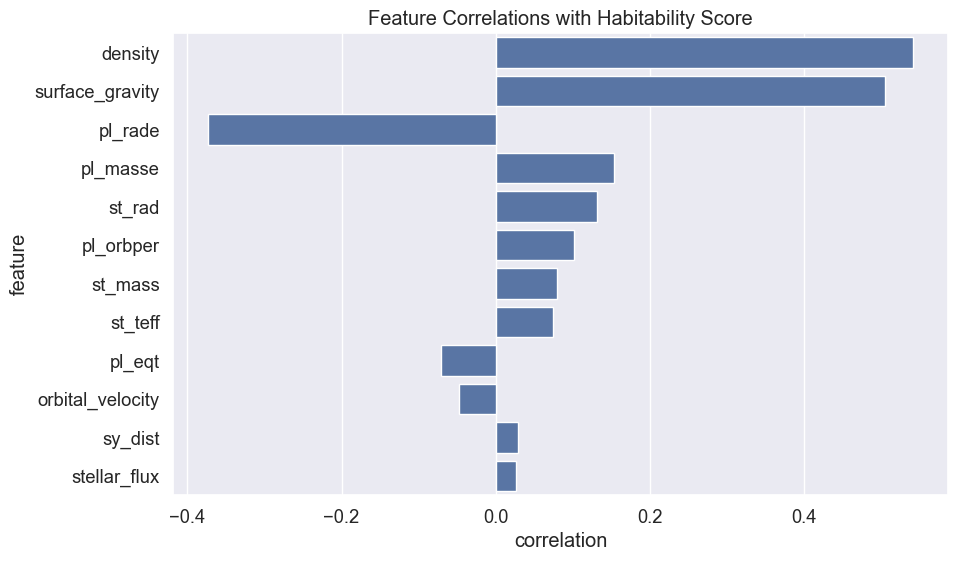

In [10]:
# Calculate derived features
df['density'] = df['pl_masse'] / (df['pl_rade'] ** 3) * 5.51  # Earth density = 5.51 g/cm³
df['surface_gravity'] = df['pl_masse'] / (df['pl_rade'] ** 2)
df['stellar_flux'] = (df['st_rad'] ** 2) * (df['st_teff'] / 5778) ** 4  # Relative to Earth
df['orbital_velocity'] = np.sqrt(df['st_mass']) / np.sqrt(df['pl_orbper'])  # Kepler's Third Law

# Feature normalization
feature_cols_extended = feature_cols + [
    'density',
    'surface_gravity',
    'stellar_flux',
    'orbital_velocity'
]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(df[feature_cols_extended])
y = df['sephi_score']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Show correlations with target
correlations = pd.DataFrame(
    {'feature': feature_cols_extended,
     'correlation': [np.corrcoef(X[:, i], y)[0, 1] for i in range(len(feature_cols_extended))]
    }
).sort_values('correlation', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=correlations, x='correlation', y='feature')
plt.title('Feature Correlations with Habitability Score')
plt.show()

## 3. XGBoost Model Development

Implement XGBoost regression model with advanced hyperparameter tuning.

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits

Best parameters found:
colsample_bytree: 0.8
gamma: 0
learning_rate: 0.1
max_depth: 3
min_child_weight: 1
n_estimators: 100
subsample: 1.0

Model Performance:
Mean Squared Error: 0.0009
R² Score: 0.9274


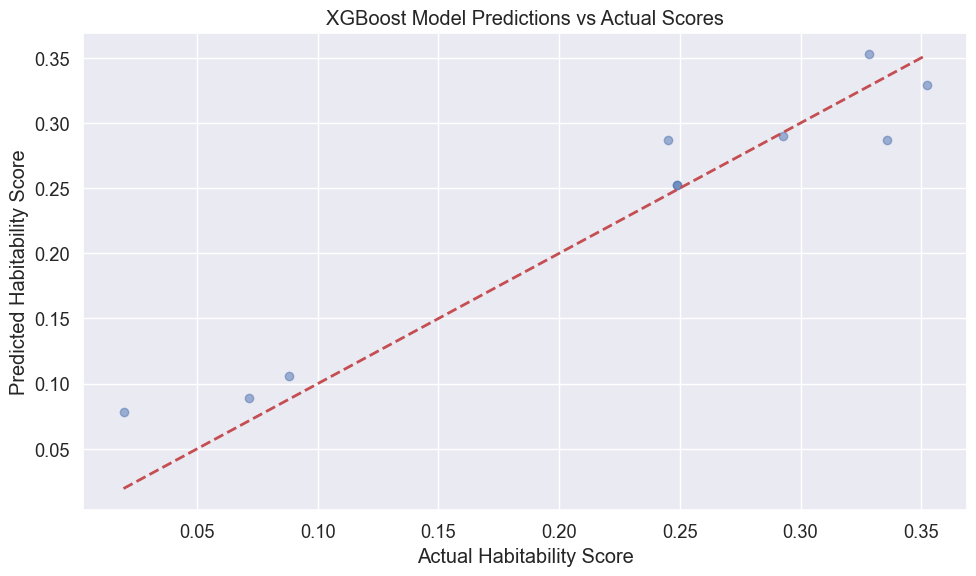

In [11]:
# Define XGBoost model with initial parameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Define parameter grid for optimization
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get best parameters
print("\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Train final model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Habitability Score')
plt.ylabel('Predicted Habitability Score')
plt.title('XGBoost Model Predictions vs Actual Scores')
plt.tight_layout()
plt.show()

## 4. Feature Importance Analysis

Analyze which features contribute most to the model's predictions.

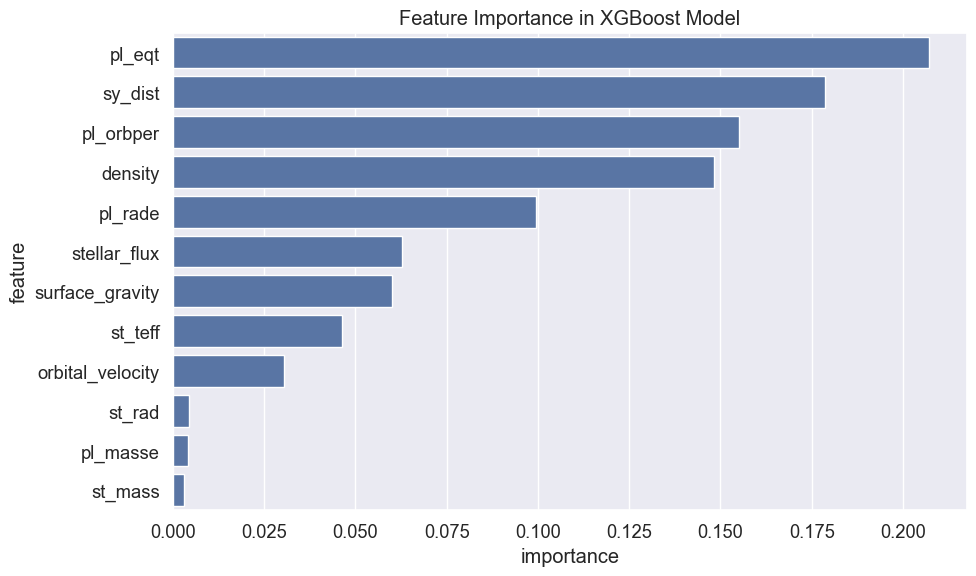


Top 5 most important features:
     feature  importance
2     pl_eqt    0.207141
5    sy_dist    0.178653
4  pl_orbper    0.155214
8    density    0.148163
0    pl_rade    0.099544


In [12]:
# Get feature importance scores
importance_scores = pd.DataFrame({
    'feature': feature_cols_extended,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_scores, x='importance', y='feature')
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(importance_scores.head())

## 5. Model Validation

Perform thorough validation using cross-validation and bootstrapping.

Cross-validation R² scores: [ 0.89764653 -0.23302271  0.78685786  0.83567947  0.87520387]
Mean R² score: 0.6325 (+/- 0.8688)


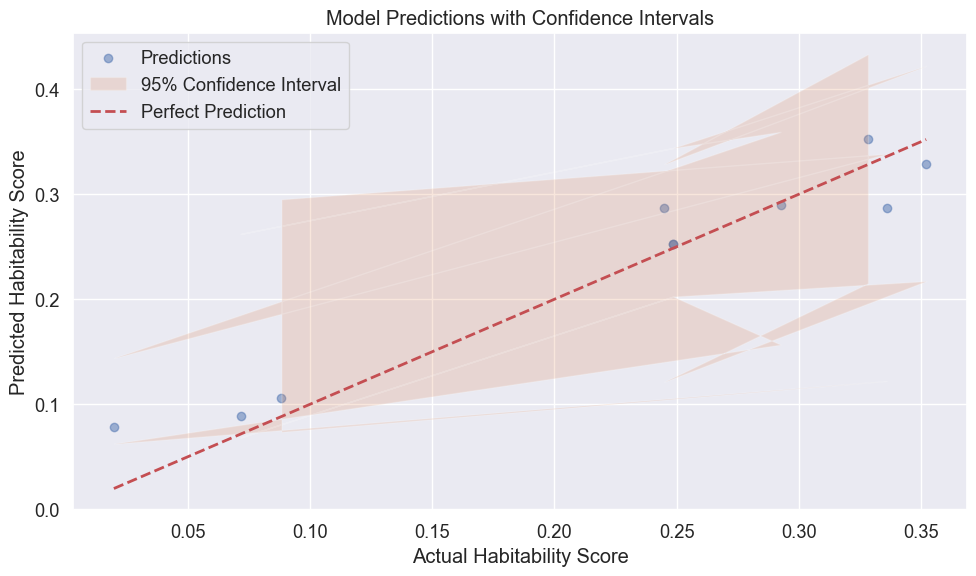

In [13]:
# Perform k-fold cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')

print("Cross-validation R² scores:", cv_scores)
print(f"Mean R² score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Bootstrap validation
n_iterations = 1000
bootstrap_predictions = np.zeros((len(X_test), n_iterations))

for i in range(n_iterations):
    # Create bootstrap sample
    indices = np.random.randint(0, len(X_train), len(X_train))
    sample_X = X_train[indices]
    sample_y = y_train.iloc[indices]
    
    # Train model and predict
    model = xgb.XGBRegressor(**grid_search.best_params_)
    model.fit(sample_X, sample_y)
    bootstrap_predictions[:, i] = model.predict(X_test)

# Calculate confidence intervals
confidence_intervals = np.percentile(bootstrap_predictions, [2.5, 97.5], axis=1)

# Plot predictions with confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.fill_between(y_test, 
                 confidence_intervals[0], 
                 confidence_intervals[1], 
                 alpha=0.2, 
                 label='95% Confidence Interval')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', 
         lw=2, 
         label='Perfect Prediction')
plt.xlabel('Actual Habitability Score')
plt.ylabel('Predicted Habitability Score')
plt.title('Model Predictions with Confidence Intervals')
plt.legend()
plt.tight_layout()
plt.show()

## 6. Save the Model

Save the trained model and preprocessing components for production use.

In [14]:
# Create a model directory if it doesn't exist
model_dir = Path('../../data_science/models')
model_dir.mkdir(exist_ok=True)

# Save the model
model_path = model_dir / 'xgboost_habitability.pkl'
scaler_path = model_dir / 'feature_scaler.pkl'
metadata_path = model_dir / 'model_metadata.json'

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

# Save model metadata
metadata = {
    'feature_columns': feature_cols_extended,
    'best_parameters': grid_search.best_params_,
    'performance': {
        'r2_score': r2,
        'mse': mse,
        'cv_scores_mean': float(cv_scores.mean()),
        'cv_scores_std': float(cv_scores.std())
    },
    'feature_importance': importance_scores.to_dict(orient='records'),
    'training_date': pd.Timestamp.now().isoformat()
}

with open(metadata_path, 'w') as f:
    import json
    json.dump(metadata, f, indent=2)

print(f"Model saved to: {model_path}")
print(f"Scaler saved to: {scaler_path}")
print(f"Metadata saved to: {metadata_path}")

Model saved to: ..\..\data_science\models\xgboost_habitability.pkl
Scaler saved to: ..\..\data_science\models\feature_scaler.pkl
Metadata saved to: ..\..\data_science\models\model_metadata.json


## 7. Test Model on Example Planets

Let's test our model on some interesting example planets, including Earth-like planets and known exoplanets.

c:\Users\satna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


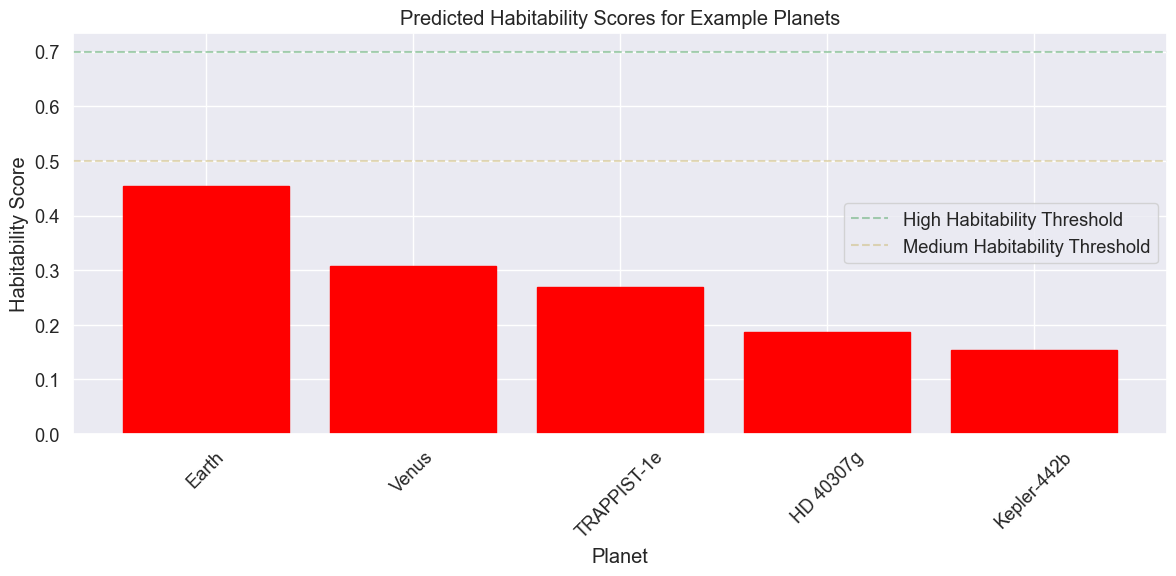


Detailed Habitability Predictions:
     Planet  Predicted Habitability Score
      Earth                      0.454047
      Venus                      0.308321
TRAPPIST-1e                      0.268430
  HD 40307g                      0.186960
Kepler-442b                      0.154851

Feature Contributions for Earth:
         Feature       Value  Importance  Contribution
         st_teff 5778.000000    0.046340    267.751206
          pl_eqt  288.000000    0.207141     59.656547
       pl_orbper  365.250000    0.155214     56.691994
         density    5.510000    0.148163      0.816381
         pl_rade    1.000000    0.099544      0.099544
    stellar_flux    1.000000    0.062645      0.062645
 surface_gravity    1.000000    0.060009      0.060009
          st_rad    1.000000    0.004368      0.004368
        pl_masse    1.000000    0.004243      0.004243
         st_mass    1.000000    0.003145      0.003145
orbital_velocity    0.052324    0.030536      0.001598
         sy_dist  

In [15]:
# Define example planets
example_planets = {
    'Earth': {
        'pl_name': 'Earth',
        'pl_rade': 1.0,  # Earth radius
        'pl_masse': 1.0,  # Earth mass
        'pl_eqt': 288,   # K (~15°C)
        'st_teff': 5778, # Sun's temperature
        'pl_orbper': 365.25,  # Earth year
        'sy_dist': 0,    # Distance from Earth
        'st_rad': 1.0,   # Sun radius
        'st_mass': 1.0   # Sun mass
    },
    'Kepler-442b': {  # Super-Earth in habitable zone
        'pl_name': 'Kepler-442b',
        'pl_rade': 1.34,
        'pl_masse': 2.36,
        'pl_eqt': 233,
        'st_teff': 4402,
        'pl_orbper': 112.3053,
        'sy_dist': 1206,
        'st_rad': 0.60,
        'st_mass': 0.61
    },
    'TRAPPIST-1e': {  # Earth-sized planet in habitable zone
        'pl_name': 'TRAPPIST-1e',
        'pl_rade': 0.92,
        'pl_masse': 0.77,
        'pl_eqt': 251,
        'st_teff': 2559,
        'pl_orbper': 6.1,
        'sy_dist': 39.6,
        'st_rad': 0.121,
        'st_mass': 0.089
    },
    'HD 40307g': {  # Super-Earth/mini-Neptune
        'pl_name': 'HD 40307g',
        'pl_rade': 1.71,
        'pl_masse': 7.1,
        'pl_eqt': 188,
        'st_teff': 4977,
        'pl_orbper': 197.8,
        'sy_dist': 42,
        'st_rad': 0.71,
        'st_mass': 0.77
    },
    'Venus': {  # Hot terrestrial planet
        'pl_name': 'Venus',
        'pl_rade': 0.95,
        'pl_masse': 0.815,
        'pl_eqt': 737,
        'st_teff': 5778,
        'pl_orbper': 224.7,
        'sy_dist': 0,
        'st_rad': 1.0,
        'st_mass': 1.0
    }
}

# Create features for example planets
example_features = []
for planet_name, planet_data in example_planets.items():
    features = [planet_data[col] for col in feature_cols]
    
    # Calculate derived features
    density = planet_data['pl_masse'] / (planet_data['pl_rade'] ** 3) * 5.51
    surface_gravity = planet_data['pl_masse'] / (planet_data['pl_rade'] ** 2)
    stellar_flux = (planet_data['st_rad'] ** 2) * (planet_data['st_teff'] / 5778) ** 4
    orbital_velocity = np.sqrt(planet_data['st_mass']) / np.sqrt(planet_data['pl_orbper'])
    
    features.extend([density, surface_gravity, stellar_flux, orbital_velocity])
    example_features.append(features)

# Scale features
X_examples = scaler.transform(example_features)

# Make predictions
predictions = best_model.predict(X_examples)

# Create results dataframe
results = pd.DataFrame({
    'Planet': list(example_planets.keys()),
    'Predicted Habitability Score': predictions
}).sort_values('Predicted Habitability Score', ascending=False)

# Plot results
plt.figure(figsize=(12, 6))
bars = plt.bar(results['Planet'], results['Predicted Habitability Score'])
plt.axhline(y=0.7, color='g', linestyle='--', alpha=0.5, label='High Habitability Threshold')
plt.axhline(y=0.5, color='y', linestyle='--', alpha=0.5, label='Medium Habitability Threshold')

# Color bars based on habitability score
for bar, score in zip(bars, results['Predicted Habitability Score']):
    if score >= 0.7:
        bar.set_color('green')
    elif score >= 0.5:
        bar.set_color('yellow')
    else:
        bar.set_color('red')

plt.title('Predicted Habitability Scores for Example Planets')
plt.xlabel('Planet')
plt.ylabel('Habitability Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print detailed results
print("\nDetailed Habitability Predictions:")
print(results.to_string(index=False))

# Calculate feature contributions for Earth
earth_features = pd.DataFrame([example_features[0]], columns=feature_cols_extended)
earth_contributions = pd.DataFrame({
    'Feature': feature_cols_extended,
    'Value': earth_features.values[0],
    'Importance': best_model.feature_importances_,
    'Contribution': earth_features.values[0] * best_model.feature_importances_
})
earth_contributions = earth_contributions.sort_values('Contribution', ascending=False)

print("\nFeature Contributions for Earth:")
print(earth_contributions.to_string(index=False))

## 8. Model Calibration

Let's calibrate our model to use Earth as a reference point, scaling the predictions to make Earth's habitability score 1.0.

Calibration scale factor: 2.2024


c:\Users\satna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\satna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


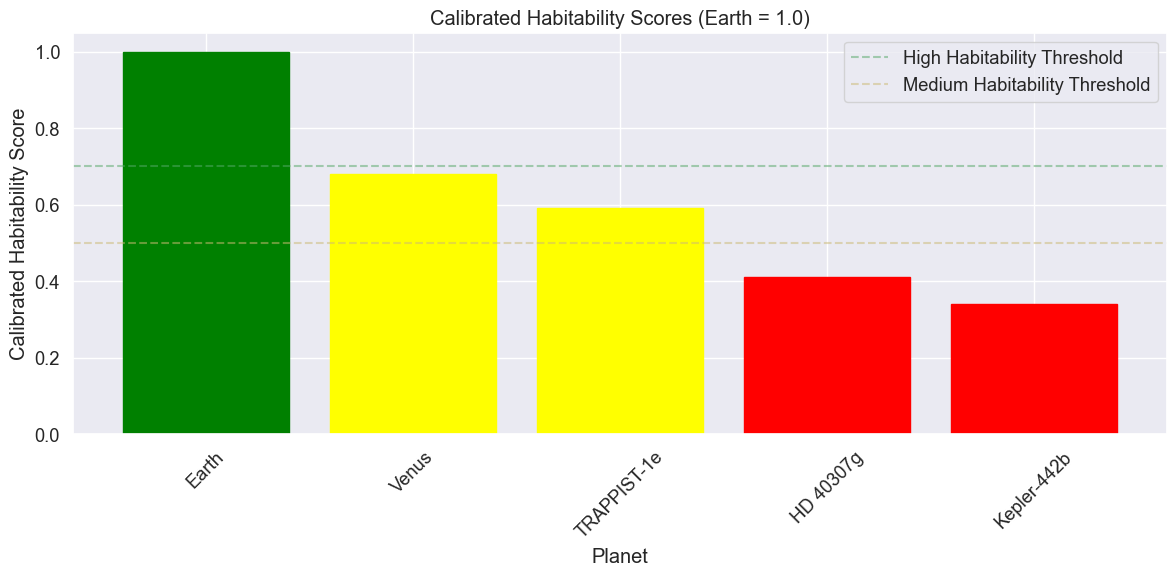


Detailed Habitability Predictions:
     Planet  Raw Score  Calibrated Score
      Earth   0.454047          1.000000
      Venus   0.308321          0.679051
TRAPPIST-1e   0.268430          0.591193
  HD 40307g   0.186960          0.411763
Kepler-442b   0.154851          0.341045

Calibrated model saved to: ..\..\data_science\models\calibrated_xgboost_habitability.pkl

Habitability Analysis:

Venus (Score: 0.679):
Top factors affecting habitability:
        feature  relative_diff     impact
        sy_dist    1206.000000 215.455627
        pl_rade       0.340000   0.033845
surface_gravity       0.314324   0.018862

TRAPPIST-1e (Score: 0.591):
Top factors affecting habitability:
         feature  relative_diff    impact
         sy_dist      39.600000  7.074662
orbital_velocity       1.308475  0.039955
        pl_masse      -0.230000 -0.000976

HD 40307g (Score: 0.412):
Top factors affecting habitability:
        feature  relative_diff   impact
        sy_dist      42.000000 7.503430
s

In [16]:
# Create a calibration class
class HabitabilityCalibrator:
    def __init__(self, model, scaler, reference_score=1.0):
        self.model = model
        self.scaler = scaler
        self.reference_score = reference_score
        self.scale_factor = None
        
    def fit(self, earth_features):
        """Calibrate using Earth's features"""
        earth_scaled = self.scaler.transform([earth_features])
        earth_pred = self.model.predict(earth_scaled)[0]
        self.scale_factor = self.reference_score / earth_pred
        print(f"Calibration scale factor: {self.scale_factor:.4f}")
        
    def predict(self, X):
        """Make calibrated predictions"""
        if self.scale_factor is None:
            raise ValueError("Calibrator must be fitted before making predictions")
        base_predictions = self.model.predict(X)
        return np.clip(base_predictions * self.scale_factor, 0, 1)

# Create and fit calibrator using Earth's features
calibrator = HabitabilityCalibrator(best_model, scaler)
earth_features = example_features[0]  # Earth is first in our example_planets
calibrator.fit(earth_features)

# Make calibrated predictions
X_examples = scaler.transform(example_features)
calibrated_predictions = calibrator.predict(X_examples)

# Create results dataframe with both raw and calibrated predictions
results = pd.DataFrame({
    'Planet': list(example_planets.keys()),
    'Raw Score': predictions,
    'Calibrated Score': calibrated_predictions
}).sort_values('Calibrated Score', ascending=False)

# Plot calibrated results
plt.figure(figsize=(12, 6))
bars = plt.bar(results['Planet'], results['Calibrated Score'])
plt.axhline(y=0.7, color='g', linestyle='--', alpha=0.5, label='High Habitability Threshold')
plt.axhline(y=0.5, color='y', linestyle='--', alpha=0.5, label='Medium Habitability Threshold')

# Color bars based on calibrated habitability score
for bar, score in zip(bars, results['Calibrated Score']):
    if score >= 0.7:
        bar.set_color('green')
    elif score >= 0.5:
        bar.set_color('yellow')
    else:
        bar.set_color('red')

plt.title('Calibrated Habitability Scores (Earth = 1.0)')
plt.xlabel('Planet')
plt.ylabel('Calibrated Habitability Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print detailed results
print("\nDetailed Habitability Predictions:")
print(results.to_string(index=False))

# Save calibrated model
calibrated_model_path = model_dir / 'calibrated_xgboost_habitability.pkl'
joblib.dump(calibrator, calibrated_model_path)
print(f"\nCalibrated model saved to: {calibrated_model_path}")

# Update metadata
metadata['calibration'] = {
    'reference_planet': 'Earth',
    'scale_factor': float(calibrator.scale_factor),
    'reference_score': 1.0
}

with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

# Calculate habitability factors
def calculate_habitability_factors(planet_name, features, calibrated_score):
    """Calculate what makes a planet more or less habitable"""
    earth_features = example_features[0]
    factors = []
    
    # Compare each feature to Earth
    for i, (feature, earth_value) in enumerate(zip(feature_cols_extended, earth_features)):
        value = features[i]
        importance = best_model.feature_importances_[i]
        
        # Calculate relative difference from Earth
        rel_diff = (value - earth_value) / earth_value if earth_value != 0 else value
        
        # Determine if this feature makes the planet more or less habitable
        impact = rel_diff * importance
        
        factors.append({
            'feature': feature,
            'value': value,
            'earth_value': earth_value,
            'relative_diff': rel_diff,
            'importance': importance,
            'impact': impact
        })
    
    return pd.DataFrame(factors).sort_values('impact', ascending=False)

# Analyze each planet's habitability factors
print("\nHabitability Analysis:")
for planet_name, features, score in zip(results['Planet'], example_features, results['Calibrated Score']):
    if planet_name != 'Earth':
        print(f"\n{planet_name} (Score: {score:.3f}):")
        factors = calculate_habitability_factors(planet_name, features, score)
        print("Top factors affecting habitability:")
        print(factors[['feature', 'relative_diff', 'impact']].head(3).to_string(index=False))